In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from anamoly import Anomaly
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm
from sklearn.model_selection import train_test_split

## Assignment: Try to find the best configuration for one of the tested algorithms


**Hypothesis:** The hypothesis is that the sensor readings of a pump will generate not normal values in case of an (upcoming) failure, and these can be determined with anomaly detection. 


We are using grid search to find the best parameters for Isolation Forest. Although Robust Covariance performed the best overall, we are optimizing Isolation Forest because it has more adjustable parameters, which could further improve its performance.

### Load Data

In [2]:
df = pd.read_csv('sensor.csv').drop('Unnamed: 0', axis=1)
df_origin = df.copy()

### Date Cleaning (Remove Unreliable Sensors)

Our previous findings showed that some sensors were unreliable. After removing them, we saw better model performance. Therefore, we are removing these unreliable sensors from the data.

In [3]:
sensors = [sensor for sensor in df.columns if sensor.startswith('sensor')]
reduced_cols = sensors[:13]+sensors[37:]+['machine_status','timestamp']
reduced_df = df[reduced_cols]

In [4]:
anomaly = Anomaly(reduced_df)
X_train, X_test, y_train, y_test = anomaly.split_train_test()
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

/home/hossain/Desktop/Eshita academic/Anomaly final/anamoly.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['timestamp'] = pd.to_datetime(df['timestamp'])


## Base Model

### Fit Model

In [5]:
outliers_fraction = 1 - (reduced_df['machine_status'].value_counts()['NORMAL']/len(reduced_df))
isolation_forest_base = IsolationForest(random_state=42)

In [6]:
isolation_forest_base.fit(X_train)

IsolationForest(random_state=42)

In [7]:
isolation_forest_preds_base = isolation_forest_base.predict(X_test)

### Evaluation

              precision    recall  f1-score   support

     Anomaly       0.75      1.00      0.86      1439
      Normal       1.00      0.98      0.99     20593

    accuracy                           0.98     22032
   macro avg       0.88      0.99      0.92     22032
weighted avg       0.98      0.98      0.98     22032



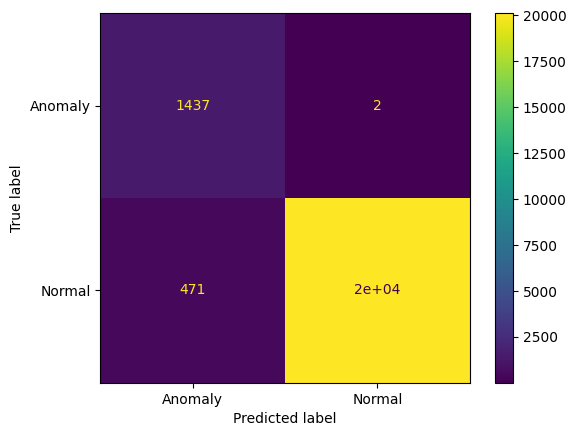

In [8]:
anomaly.evaluation(isolation_forest_preds_base, y_test)

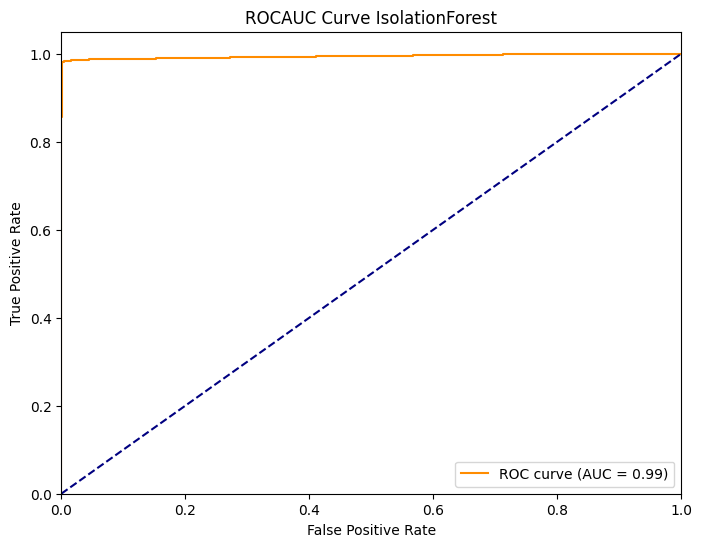

In [9]:
tpr_iso1, fpr_iso_1,auc_iso1 = anomaly.return_tpr_fpr_auc(isolation_forest_base, X_test, y_test)
model_name_iso= str(isolation_forest_base).split('(')[0]
anomaly.plot_auc(model_name_iso,tpr_iso1, fpr_iso_1,auc_iso1)

### Model Selection

In [10]:
anomaly = Anomaly(reduced_df)

/home/hossain/Desktop/Eshita academic/Anomaly final/anamoly.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['timestamp'] = pd.to_datetime(df['timestamp'])


In [11]:
isolation_forest = IsolationForest()

In [12]:
param_grid = {
    'n_estimators': [50, 100, 200],       # Number of trees
    'max_samples': ['auto', 0.8, 1.0],    # Sample size for each tree
    'contamination': ['auto', 0.01, 0.05, 0.1],   # Expected proportion of outliers
    'max_features': [1.0, 0.8, 0.5],      # Number of features to consider
    'bootstrap': [True, False],           # Whether to bootstrap samples
    'random_state': [42]
}

In [13]:
best_params = anomaly.find_best_params(isolation_forest, X_val, y_val, param_grid=param_grid)

In [14]:
best_params

{'bootstrap': True,
 'contamination': 'auto',
 'max_features': 1.0,
 'max_samples': 'auto',
 'n_estimators': 50,
 'random_state': 42}

### Train and Evaluate Model

In [15]:
isolation_forest_best = IsolationForest(**best_params)

In [16]:
isolation_forest_best.fit(X_train)

IsolationForest(bootstrap=True, n_estimators=50, random_state=42)

In [17]:
isolation_forest_preds = isolation_forest_best.predict(X_test)

              precision    recall  f1-score   support

     Anomaly       0.75      0.98      0.85      1439
      Normal       1.00      0.98      0.99     20593

    accuracy                           0.98     22032
   macro avg       0.88      0.98      0.92     22032
weighted avg       0.98      0.98      0.98     22032



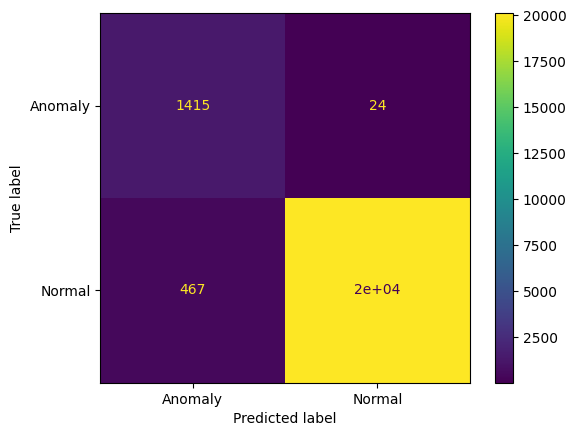

In [18]:
anomaly.evaluation(isolation_forest_preds, y_test)

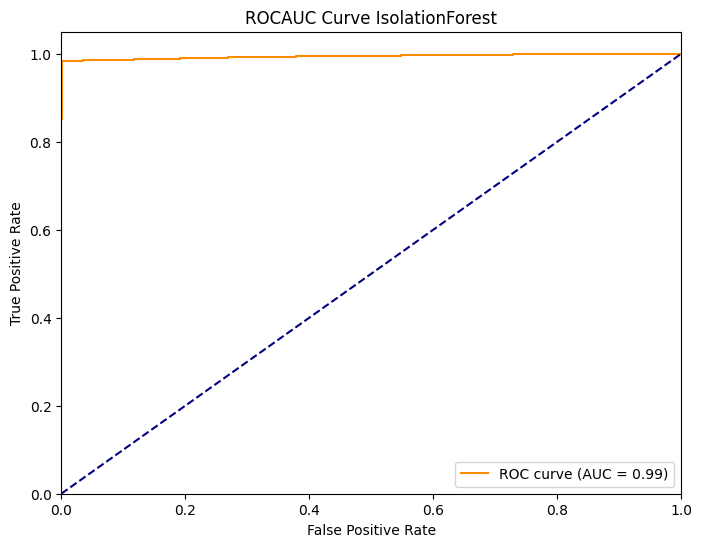

In [19]:
tpr_iso1, fpr_iso_1,auc_iso1 = anomaly.return_tpr_fpr_auc(isolation_forest_best, X_test, y_test)
model_name_iso= str(isolation_forest_best).split('(')[0]
anomaly.plot_auc(model_name_iso,tpr_iso1, fpr_iso_1,auc_iso1)

With this configuration, we did not observe an improvement in the F1 score compared to the base model. The base model achieved an anomaly F1 score of 0.86, while the best-configured model scored slightly lower at 0.85. Additionally, the AUC remained the same for both models. Notably, the best-configured model produced more false positives than the base model. The only parameter difference between the two models was the number of estimators in the Isolation Forest. Below is a comparison of their parameters.

| Parameter      | Default Value       | Optimized Value  |
|--------------|-------------------|-----------------|
| bootstrap    | False             | True           |
| contamination | auto              | auto            |
| max_features | 1.0               | 1.0             |
| max_samples  | auto              | auto            |
| n_estimators | 100               | 50              |



### Comparison in validation set

              precision    recall  f1-score   support

     Anomaly       0.77      1.00      0.87      1382
      Normal       1.00      0.98      0.99     20650

    accuracy                           0.98     22032
   macro avg       0.88      0.99      0.93     22032
weighted avg       0.99      0.98      0.98     22032



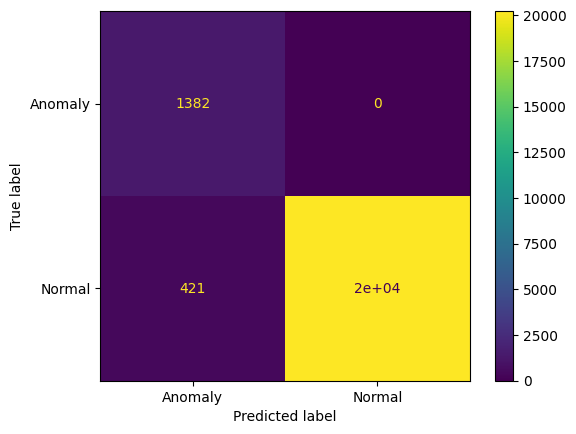

In [20]:
isolation_forest_preds_best_val = isolation_forest_best.predict(X_val)
anomaly.evaluation(isolation_forest_preds_best_val, y_val)

              precision    recall  f1-score   support

     Anomaly       0.76      1.00      0.86      1382
      Normal       1.00      0.98      0.99     20650

    accuracy                           0.98     22032
   macro avg       0.88      0.99      0.93     22032
weighted avg       0.98      0.98      0.98     22032



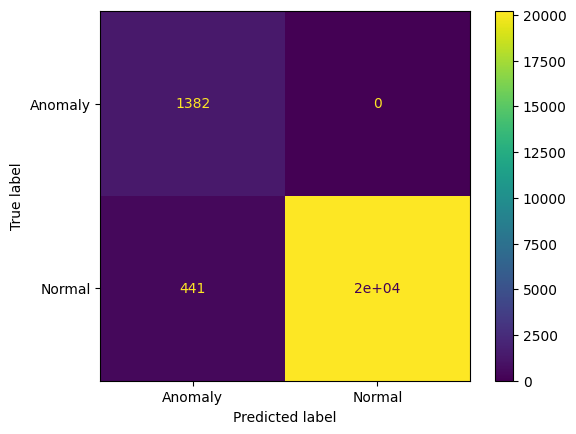

In [21]:
isolation_forest_preds_val = isolation_forest_base.predict(X_val)
anomaly.evaluation(isolation_forest_preds_val, y_val)

We selected the best model configuration based on its performance on the validation set, and as expected, this best-configured model performed better on the validation set compared to the base model. However, the base model proved to be more robust, maintaining consistent performance on the test set. In contrast, the best-configured model, despite its strong validation performance, failed to generalize well to the test set. This suggests that the base model is more reliable and less prone to overfitting.